# Unsupervised learning using Bayesian Mixture Models

Inferring a latent grouping from unlabeled data

$\mathbf{x} = {x_i}_{i=1}^{N}, x \in {\rm I\!R}^2$ distributed according to Gaussian distributions.

First, generate synthetic dataset

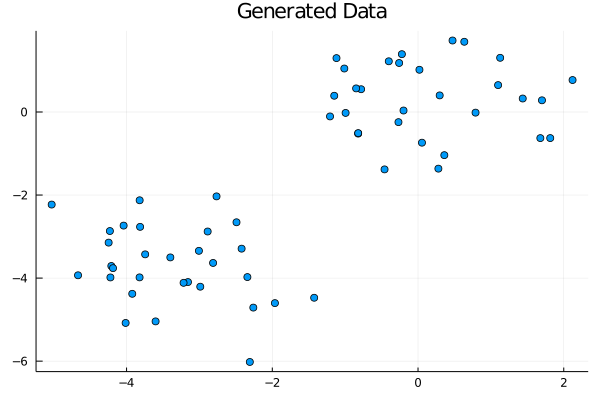

In [1]:
using Distributions, StatsPlots, Random

Random.seed!(3)
N = 30 # per cluster

# Means
cluster_means = [-3.5, 0.0]

# Data 
x = mapreduce( c -> rand(MvNormal([cluster_means[c], cluster_means[c]], 1.0), N), hcat, 1:2)

# Visualize
scatter(x[1,:], x[2,:], legend=false, title="Generated Data")

Next start to build the Gaussian mixture model. 

Data generation for a Bayesian Gaussian mixture model starts by drawing parameters of each distribution:

$$
\mu_k \sim \text{Normal}(), \forall k
$$

Then draw mixing weight from a Dirichlet distribution

$$
w \sim \text{Dirichlet}(K,\alpha)
$$

Then generate an observation by selection a cluster with a categorical distribution and draw data accordingly

$$
z_i \sim \text{Categorical}(w), \forall ix_i \sim \text{Normal}(\mu_{z_i}, 1), \forall i
$$

In [2]:
using Turing, MCMCChains

In [3]:
@model GaussianMixtureModel(x) = begin

    # Get dimensions, number of points
    D, N = size(x)

    # Draw parameters for each cluster
    mu1 ~ Normal()
    mu2 ~ Normal()

    mu = [mu1, mu2]

    # Draw weights from Dirichlet
    alpha = 1.0
    w ~ Dirichlet(2, alpha)

    # Draw assignments for each datum and generate it from a MV normal
    k = Vector{Int}(undef, N)
    for i in 1:N
        k[i] ~ Categorical(w)
        x[:, i] ~ MvNormal([mu[k[i]], mu[k[i]]], 1.0)
    end
    return k
end

GaussianMixtureModel (generic function with 1 method)

In [4]:
gmm_model = GaussianMixtureModel(x);

Draw observations from the posterior using particle gibbs sampler.

Combine both samplers for Bayesian inference in the model, generate multiple chains then run `chainscat` to add together.

In [5]:
gmm_sampler = Gibbs(PG(100, :k), HMC(0.05, 10, :mu1, :mu2))
tchain = mapreduce(c -> sample(gmm_model, gmm_sampler, 100), chainscat, 1:3);

Sampling: 100%|█████████████████████████████████████████| Time: 0:03:18
Sampling: 100%|█████████████████████████████████████████| Time: 0:03:23
Sampling: 100%|█████████████████████████████████████████| Time: 0:03:38


### Visualization

First, visualize the trace and density of parameters of interest.

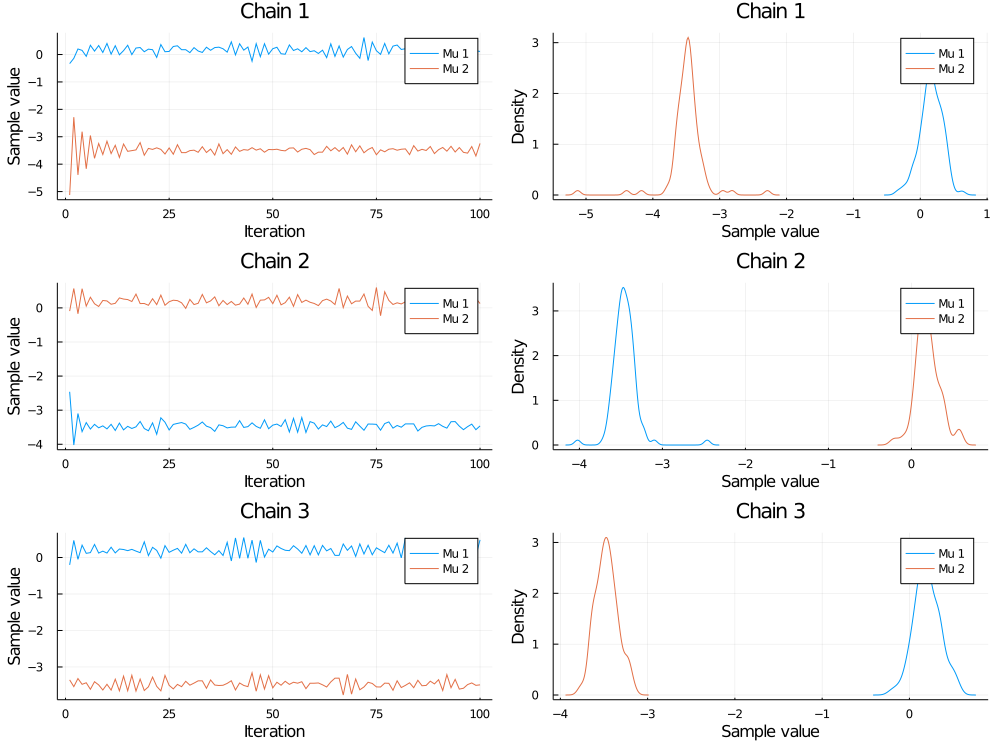

In [6]:
ids = [:mu1, :mu2]
p=plot(tchain[:, ids, :], legend=true, labels = ["Mu 1" "Mu 2"], colordim=:parameter)

I'm personally curious how the Dirichlet distribution worked out as well.

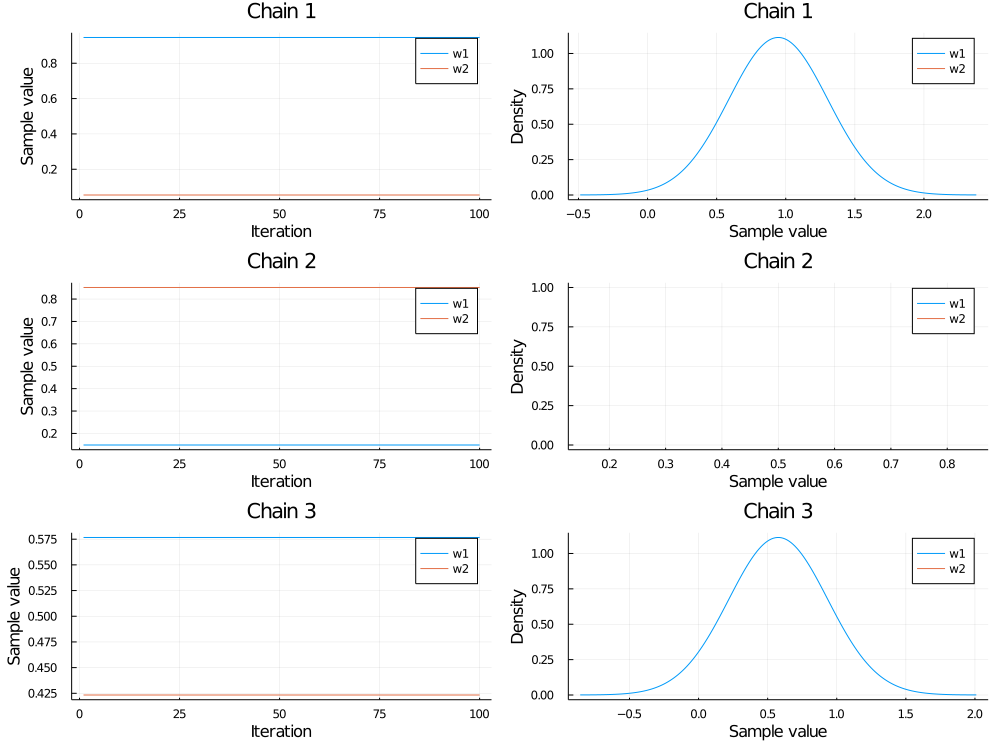

In [7]:
ids = findall(map(name -> occursin("w", String(name)), names(tchain)));
p=plot(tchain[:, ids, :], legend=true, labels = ["w1" "w2"], colordim=:parameter)


One thing to note here is that the standard non-identifiability problem shows up here, noted by the switching means. This notebook does not cover resolving it, rather just starts working with a single chain for sake of ease.

In [8]:
# use only first chain
ch = tchain[:, :, 1]
# Prediction function to visualize density region
function predict(x, y, w, mu)
    # Use log-sum-exp trick for numeric stability
    return Turing.logaddexp(
        log(w[1]) + logpdf(MvNormal([mu[1], mu[1]], 1), [x, y]),
        log(w[2]) + logpdf(MvNormal([mu[2], mu[2]], 1), [x, y])
    )
end;

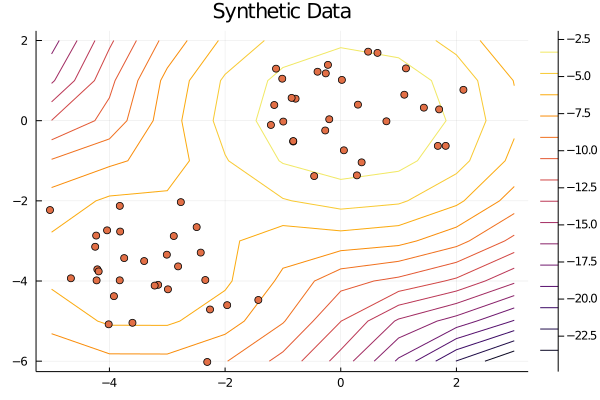

In [9]:
contour(range(-5, stop = 3), range(-6, stop = 2), 
    (x, y) -> predict(x, y, [mean(ch["w[1]"]), mean(ch["w[2]"])], [mean(ch[:mu1]), mean(ch[:mu2])])
)
scatter!(x[1,:], x[2,:], legend = false, title = "Synthetic Data")

Last, inspect the infered assignments of the data points using this model

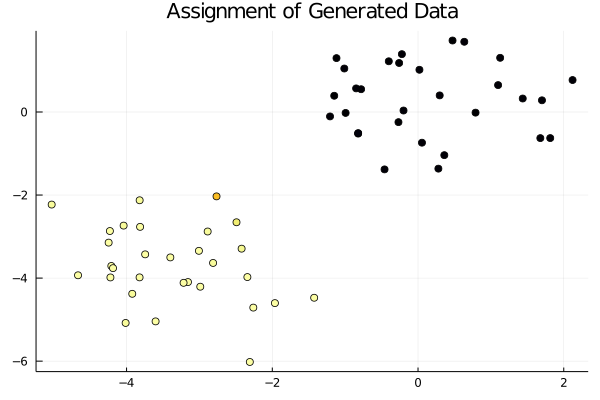

In [10]:
assignments = map(mean, get(tchain, :k).k) |> collect
scatter(x[1,:], x[2,:],
    legend = false,
    title = "Assignment of Generated Data",
    zcolor = assignments
)